In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, learning_curve, GridSearchCV, ShuffleSplit, train_test_split, RepeatedKFold
from sklearn.neighbors import KNeighborsClassifier   
from numpy import mean, std
from sklearn.decomposition import PCA
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import roc_curve, auc 
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import OneHotEncoder

In [2]:
df = pd.read_csv('C:/Users/norma/Desktop/BITIRME/Without_MCI_GSE_OrtakData_NormR.csv', sep = ";", decimal=",")
# Keeping only 2 classes which are AD and CTL
df = df[df.Class != 2]

In [3]:
features = df.drop('Class',axis=1)
labels_dr = 'C:/Users/norma/Desktop/BITIRME/OneHotEncoded_Labels.csv'
labels_df = pd.read_csv(labels_dr, sep = ',')
labels = labels_df.iloc[:949,:2]

### PCA WITH N COMPONENTS = 225

In [4]:
n_components = 225
pca = PCA(n_components = n_components).fit(features)
principalComponents = pca.fit_transform(features)
columns = ['Pc' + str(i) for i in range(1,n_components+1)]
principalDf = pd.DataFrame(data = principalComponents
             , columns = columns)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(principalDf, labels, test_size= 0.25, random_state=42)

In [6]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [13]:
class_d = 'C:/Users/norma/Desktop/BITIRME/LabelEncoded_GSE_OrtakData_NormR.csv'
class_df = pd.read_csv(class_d, sep = ';', decimal = ',')
class_df = class_df[class_df.Class != 2]

#creating instance of one-hot-encoder
encoder = OneHotEncoder(handle_unknown='ignore')

encoder_df = pd.DataFrame(encoder.fit_transform(class_df[['Class']]).toarray())
encoder_df.columns = ['AD','CTL']

y_test = encoder.inverse_transform(y_test).ravel()

## List Hyperparameters to Tune
### I selected optimal parameters manually because GridSearchCV was taking too much time

In [14]:
p=[1,2]

optimal_p = 0
best_auc = 0
for i in p:
    knn = KNeighborsClassifier(p = i)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    fpr, tpr, threshold = roc_curve(y_test, y_pred[:,1])
    auc_knn = auc(fpr,tpr)
    if best_auc < auc_knn:
        best_auc = auc_knn
        optimal_p = i

print("Optimal p: {}, The Best AUC Score: {}".format(optimal_p,best_auc))

Optimal p: 1, The Best AUC Score: 0.6470588235294119


In [15]:
n_neighbors = list(range(1,60))

optimal_n_neighbors = 0
best_auc = 0
for i in n_neighbors:
    knn = KNeighborsClassifier(n_neighbors = i, p=1)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    fpr, tpr, threshold = roc_curve(y_test, y_pred[:,1])
    auc_knn = auc(fpr,tpr)
    if best_auc < auc_knn:
        best_auc = auc_knn
        optimal_n_neighbors = i

print("Optimal N-Neighbors: {}, The Best AUC Score: {}".format(optimal_n_neighbors,best_auc))

Optimal N-Neighbors: 18, The Best AUC Score: 0.6848739495798319


In [19]:
optimal_weights = 'uniform'
best_auc = 0
weights = ['uniform', 'distance']
for i in weights:
    knn = KNeighborsClassifier(n_neighbors = 18, p = 1, weights = i)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    fpr, tpr, threshold = roc_curve(y_test, y_pred[:,1])
    auc_knn = auc(fpr,tpr)
    if best_auc < auc_knn:
        best_auc = auc_knn
        optimal_weights = i

print("Optimal Weights: {}, The Best AUC Score: {}".format(optimal_weights,best_auc))


Optimal Weights: uniform, The Best AUC Score: 0.6848739495798319


# Optimal K-NN Model

The Best AUC Score: 0.6848739495798319
Classification report : 
               precision    recall  f1-score   support

           1       0.67      0.73      0.70       119
           0       0.70      0.64      0.67       119

    accuracy                           0.68       238
   macro avg       0.69      0.68      0.68       238
weighted avg       0.69      0.68      0.68       238



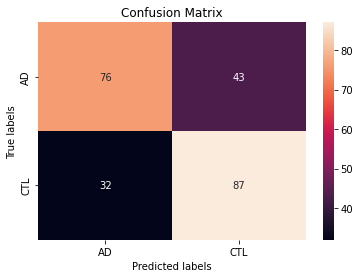

In [21]:
knn = KNeighborsClassifier(n_neighbors = 18, p = 1, weights = 'uniform')
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
fpr, tpr, threshold = roc_curve(y_test, y_pred[:,1])
auc_knn = auc(fpr,tpr)
print("The Best AUC Score: {}".format(auc_knn))

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(y_test,y_pred[:,1],labels=[1,0])
print('Classification report : \n',matrix)

labels = ['AD','CTL']
ax= plt.subplot()

# confusion matrix
matrix = confusion_matrix(
    y_test, y_pred.argmax(axis=1))

sns.heatmap(matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);

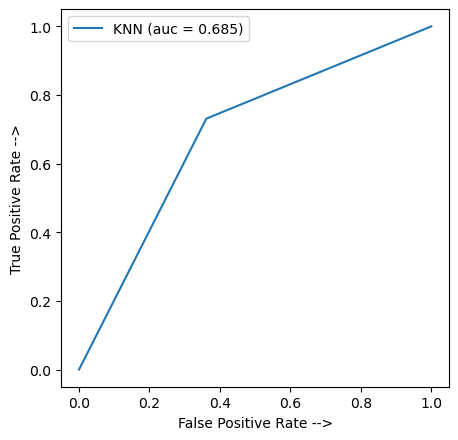

In [24]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, threshold = roc_curve(y_test, y_pred[:,1])
auc_knn = auc(fpr,tpr)

plt.figure(figsize=(5,5), dpi=100)
plt.plot(fpr, tpr, linestyle = '-', label = 'KNN (auc = %0.3f)' % auc_knn)

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.legend()
plt.show()

# SAVE MODEL

In [30]:
filename = 'C:/Users/norma/Desktop/src/KNN.h5'
joblib.dump(knn, filename)

['C:/Users/norma/Desktop/src/KNN.h5']

In [31]:
# Load the model from the file
knn_from_joblib = joblib.load(filename)
 
# Use the loaded model to make predictions
y_pred_load = knn_from_joblib.predict(x_test)

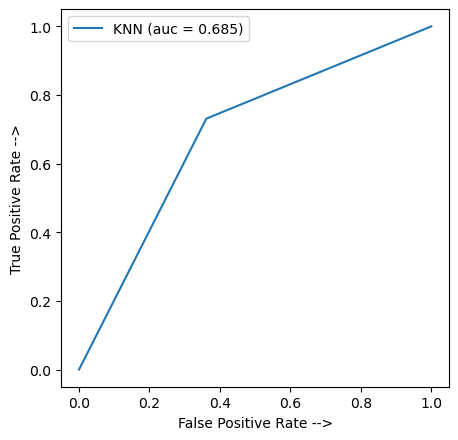

In [32]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, threshold = roc_curve(y_test, y_pred[:,1])
auc_knn = auc(fpr,tpr)

plt.figure(figsize=(5,5), dpi=100)
plt.plot(fpr, tpr, linestyle = '-', label = 'KNN (auc = %0.3f)' % auc_knn)

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.legend()
plt.show()